# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
import torchvision
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
import numpy as np
import shutil
from tqdm import tqdm
import random

# Loading CIFAR10 dataset

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(root='./data_cifar', train=True,
                                        download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR10(root='./data_cifar', train=False,
                                       download=True, transform=transform_test)

batch_size = 128

c, w, h = 3, 32, 32

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=batch_size,
                                         shuffle=True)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
classes_org = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
# choose a picture at random
im_minibatch, label_minibatch = next(iter(testloader))
im, label = im_minibatch[0].cpu(), label_minibatch[0].cpu()

# store image size dimensions
image_size = tuple(im.shape)

# Loading MobileNetV2 model

In [6]:
def load_model(classes):
    model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False)

    # Replace the final fully-connected layer
    num_ftrs = model.classifier[1].in_features
    model.classifier[1] = torch.nn.Linear(num_ftrs, len(classes))
    
    return model

In [7]:
model_org = load_model(classes_org)
model_org.to(device)
print(model_org)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

Using cache found in C:\Users\raulv/.cache\torch\hub\pytorch_vision_v0.10.0
C:\Users\raulv\Desktop\1B\Deep Learning from Theory to Practice\Tutorials\dl_course-env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\raulv\Desktop\1B\Deep Learning from Theory to Practice\Tutorials\dl_course-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# Training

In [8]:
def train_model(model, trainloader, testloader, weights_dir, num_epochs=200):
    start=time.time()
    
    error = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(0,num_epochs):

        model.train()  # Put the network in train mode
        for i, (x_batch, y_batch) in enumerate(trainloader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move the data to the device that is used

            optimizer.zero_grad()  # Set all currenly stored gradients to zero 

            y_pred = model(x_batch)

            loss = error(y_pred, y_batch)

            loss.backward()

            optimizer.step()

            # Compute relevant metrics

            y_pred_max = torch.argmax(y_pred, dim=1)  # Get the labels with highest output probability

            correct = torch.sum(torch.eq(y_pred_max, y_batch)).item()  # Count how many are equal to the true labels

            elapsed = time.time() - start  # Keep track of how much time has elapsed

            # Show progress every 20 batches 
            if not i % 20:
                print(f'epoch: {epoch}, time: {elapsed:.3f}s, loss: {loss.item():.3f}, train accuracy: {correct / batch_size:.3f}')

        correct_total = 0

        model.eval()  # Put the network in eval mode
        for i, (x_batch, y_batch) in enumerate(testloader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move the data to the device that is used

            y_pred = model(x_batch)
            y_pred_max = torch.argmax(y_pred, dim=1)

            correct_total += torch.sum(torch.eq(y_pred_max, y_batch)).item()

        print(f'Accuracy on the test set: {correct_total / len(testset):.3f}')

        # Save weights every 10 epochs
        if epoch%10==0:
            torch.save(model.state_dict(), f"./{weights_dir}/epoch-{epoch}_accuracy-{correct_total/len(testset):.3f}.pth")
    

In [ ]:
if os.path.exists(os.path.join('weights')):
    shutil.rmtree(os.path.join('weights'))
!mkdir weights

In [ ]:
train_model(model_org, trainloader, testloader, 'weights')

# Load latest weights

In [9]:
def load_weights(classes, model, weights_dir):
    files = os.listdir(weights_dir)
    weight_paths = [os.path.join(weights_dir, basename) for basename in files]
    final_weight_file = os.path.basename(max(weight_paths, key=os.path.getctime))

    model = load_model(classes)

    model.load_state_dict(torch.load(os.path.join(weights_dir, final_weight_file), map_location=device))
    print('Loaded weights: ' + final_weight_file)
    
    return model

In [10]:
model_org = load_weights(classes_org, model_org, 'weights')
model_org.to(device)
# sets the module in eval node
model_org.eval()

Using cache found in C:\Users\raulv/.cache\torch\hub\pytorch_vision_v0.10.0


Loaded weights: epoch-190_accuracy-0.840.pth


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

# Evaluation

In [11]:
def show(X):
    X = inverse_transform(X)

    plt.imshow(np.transpose(X.numpy(), (1, 2, 0)))
    plt.show()
    
inverse_transform = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ], std = [ 1/0.229, 1/0.224, 1/0.225 ]), 
                                        transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ]),])

In [12]:
def show_examples(classes, testloader, model):
    dataiter = iter(testloader)
    images, labels = next(dataiter)

    # print images
    show(torchvision.utils.make_grid(images[:16]))
    print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(16)))

    images = images.to(device)
    outputs = model(images)

    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                                  for j in range(16)))

In [13]:
def show_accuracies(classes, testloader, model):
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # again no gradients needed
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

    correct_total = 0
    for i, (x_batch, y_batch) in enumerate(testloader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move the data to the device that is used

        y_pred = model(x_batch)
        y_pred_max = torch.argmax(y_pred, dim=1)

        correct_total += torch.sum(torch.eq(y_pred_max, y_batch)).item()

    print(f'\nAccuracy on the test set: {correct_total / len(testset):.3f}')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


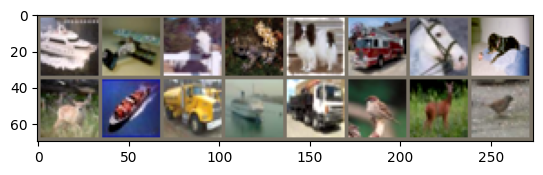

GroundTruth:  ship  plane horse frog  dog   truck horse dog   deer  ship  truck ship  truck bird  deer  bird 
Predicted:  ship  cat   horse frog  dog   truck horse cat   deer  ship  truck ship  truck bird  deer  bird 


In [14]:
show_examples(classes_org, testloader, model_org)

In [15]:
show_accuracies(classes_org, testloader, model_org)

Accuracy for class: plane is 83.6 %
Accuracy for class: car   is 92.3 %
Accuracy for class: bird  is 81.7 %
Accuracy for class: cat   is 64.0 %
Accuracy for class: deer  is 82.9 %
Accuracy for class: dog   is 79.9 %
Accuracy for class: frog  is 86.7 %
Accuracy for class: horse is 86.8 %
Accuracy for class: ship  is 91.0 %
Accuracy for class: truck is 91.0 %

Accuracy on the test set: 0.840


# Adversarial attack

In [16]:
class GeneticSolver:
    def __init__(self, model, image_size, population_size=100, n_generations=1000, retain_best=0.8, retain_random=0.05, mutate_chance=0.05,
                 verbosity=0, verbose_step=50, random_state=None, warm_start=False, early_stopping=True, patience=20):
        """
        :param population_size: number of individual candidate solutions
        :param n_generations: number of generations
        :param retain_best: percentage of best candidates to select into the next generation
        :param retain_random: probability of selecting sub-optimal candidate into the next generation
        :param mutate_chance: candidate mutation chance
        :param verbosity: level of verbosity (0 - quiet, 1 - evolution information, 2 - spamming like it's 2003)
        :param verbosity_step: number of generations to process before showing the best score
        :param random_state: if specified, initializes seed with this value
        :param warm_start: if True, initial population generation step is omitted, allowing for continuing training
        :param early_stopping: if True, evolution will stop if top-10 candidates are not changing for several generations
        :param patience: number of generations to wait for best solution change when <early_stopping>
        """
        self.image_size = image_size
        self.population_size = population_size
        self.n_generations = n_generations
        self.retain_best = retain_best
        self.retain_random = retain_random
        self.mutate_chance = mutate_chance
        self.verbosity = verbosity
        self.verbosity_step = verbose_step
        self.random_state = random_state
        self.warm_start = warm_start
        self.early_stopping = early_stopping
        self.patience = patience
        self.model = model

        self._population = None

    def solve(self, fitness_fn, n_generations=-1, verbose_step=None):
        """
        :param fitness_fn: function to optimize w.r.t.
        :param n_generations: number of evolution generations. Overrides initialization value if specified
        :return: best gene from the population pool. You can still have access to population and the corresponding scores afterwards
        """
        if verbose_step is None:
            verbose_step = self.verbose_step
        if self.random_state is not None:
            np.random.seed(self.random_state)
        if self._population is None or self.warm_start:
            self._population = self._generate_population(self.image_size)
    
        if n_generations != -1:
            self.n_generations = n_generations
    
        scores = np.zeros(len(self._population))
        prev_scores = np.zeros(len(self._population))
        cnt_no_change_in_scores = 0

        for generation in range(self.n_generations):
            self._population, scores = self.evolve(fitness_fn)
            if np.isclose(prev_scores[:10], scores[:10]).all():
                cnt_no_change_in_scores += 1
            else:
                cnt_no_change_in_scores = 0
                prev_scores = scores
            
            if self.verbosity:
                if generation == 0:
                    print("Generation #: best score")
                elif generation == self.n_generations - 1:
                    print("Generation ",generation,": ",scores[0])
                elif generation % verbose_step == 0:
                    print("Generation ",generation,": ",scores[0])
                    
            if np.isclose(scores[:10], 1).any() or (self.early_stopping and cnt_no_change_in_scores >= self.patience):
                if self.verbosity:
                    print("Early stopping on generation ",generation, " with best score ", scores[0])
                break

        return self._population[0], scores[0]

    def _generate_population(self, image_size):
        """
        Generating initial population of individual solutions
        :return: initial population as an array
        """
        return np.random.rand(self.population_size, *image_size)

    def evolve(self, fitness_fn):
        """
        Evolution step
        :return: new generation of the same size along with scores of the best retained individuals
        """
        scores = np.array(self.score_population(self._population, fitness_fn))
        
        retain_len = int(len(scores) * self.retain_best)
        sorted_indices = np.argsort(scores)[::-1]
        self._population = [self._population[idx] for idx in sorted_indices]
        best_scores = scores[sorted_indices][:retain_len]
        if self.verbosity > 1:
            print("best scores:", best_scores)
        parents = self._population[:retain_len]
        leftovers = self._population[retain_len:]

        cnt_degenerate = 0
        for gene in leftovers:
            if np.random.rand() < self.retain_random:
                cnt_degenerate += 1
                parents.append(gene)
        if self.verbosity > 1:
            print("# of degenerates left: ", cnt_degenerate)

        cnt_mutations = 0
        for gene in parents[1:]:  # mutate everyone expecting for the best candidate
            if np.random.rand() < self.mutate_chance:
                self.mutate(gene, self.image_size)
                cnt_mutations += 1
        if self.verbosity > 1:
            print("# of mutations: ", cnt_mutations)

        places_left = self.population_size - retain_len
        children = []
        while len(children) < places_left:
            mom_idx, dad_idx = np.random.randint(0, retain_len - 1, 2)
            if mom_idx != dad_idx:
                child1, child2 = self.crossover(parents[mom_idx], parents[dad_idx], self.image_size)
                children.append(child1)
                if len(children) < places_left:
                    children.append(child2)
        if self.verbosity > 1:
            print("# of children: ", len(children))
        parents.extend(children)
        return parents, best_scores

    @classmethod
    def crossover(cls, mom, dad, image_size):
        """
        Take two parents, return two children, interchanging half of the allels of each parent randomly
        """
        # select_mask = np.random.randint(0, 2, size=(20, 20), dtype='bool')
        select_mask = np.random.binomial(1, 0.5, size=image_size).astype('bool')
        child1, child2 = np.copy(mom), np.copy(dad)
        child1[select_mask] = dad[select_mask]
        child2[select_mask] = mom[select_mask]
        return child1, child2

    @classmethod
    def mutate(cls, field, image_size):
        """
        Inplace mutation of the provided field
        """
        a = np.random.binomial(1, 0.1, size=image_size).astype('bool')
        field[a] = np.clip(field[a] + np.random.randn(*field[a].shape) * 0.1, 0, 1)
        return field

    def score_population(self, population, fitness_function):
        """
        Apply fitness function for each gene in a population
        :param population: list of candidate solutions (images)
        :return: list/1d-array of scores for each solution
        """
        if type(population) is list:
            population = np.array(population)
            
        return fitness_function(population, self.model)

In [17]:
def fitness_class_probability_empty(X, model):
    """ Maximize probability of adversarial target class, penalizing mean pixel intensity"""
    y = model(torch.Tensor(X).to(device)).to('cpu').detach().numpy()
    y_target = y[:, adv_target]
    X_mean = X.mean(axis=1).mean(axis=1).mean(axis=1)
    return y_target - X_mean

In [18]:
def show_probabilities(X, model, classes):
    if isinstance(X, np.ndarray):
        X = torch.Tensor(X)
    prob = F.softmax(model(X.unsqueeze(0).to(device)), dim=1)

    print('Confidence scores:\n' + '\n'.join(['{}: {}'.format(classes[i], p.item()) for i, p in enumerate(prob.squeeze())]))    
    print('\nLabel with highest confidence score: {}'.format(classes[torch.argmax(prob).item()]))

## Attack with a single sample

In [20]:
adv_target = classes_org.index('frog')
m = GeneticSolver(model_org, image_size=image_size, verbosity=True, verbose_step=100, warm_start=True, early_stopping=False)
res, score = m.solve(fitness_class_probability_empty, n_generations=1000, verbose_step=500)

Generation #: best score
Generation  500 :  16.646500973071987
Generation  999 :  17.36502974026572


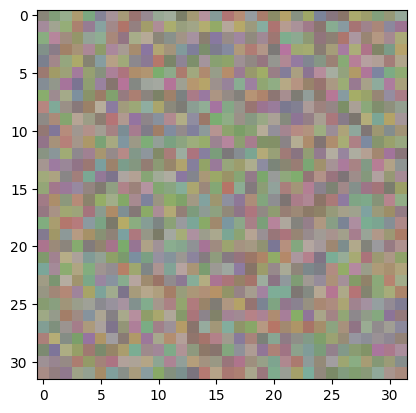

Confidence scores:
plane: 8.448029763147599e-24
car: 9.237162825380912e-25
bird: 9.630026810703018e-13
cat: 3.4276812396321623e-15
deer: 3.0116133913498414e-19
dog: 1.8064815661693497e-15
frog: 1.0
horse: 1.151218358542376e-20
ship: 1.05273586251585e-21
truck: 1.2634920061660792e-22

Label with highest confidence score: frog


In [21]:
show(torch.Tensor(res))
show_probabilities(res, model_org, classes_org)

## Generating a dataset of adversarial examples

In [22]:
generate_adversarial_dataset = False

if generate_adversarial_dataset:
    if os.path.exists(os.path.join('adversarial_dataset')):
        shutil.rmtree(os.path.join('adversarial_dataset'))
    !mkdir adversarial_dataset

In [23]:
# set number of images to generate per class
numImgsPerClass = 600

In [ ]:
noise_data = []

for aClass in classes_org:
    print('Generating adversarial examples for class: ' + aClass)
    
    for i in tqdm(range(0,numImgsPerClass)):
        adv_target = classes_org.index(aClass)
        m = GeneticSolver(model_org, image_size=image_size, verbosity=False, verbose_step=100, warm_start=True, early_stopping=False)
        adv_img, score = m.solve(fitness_class_probability_empty, n_generations=1000, verbose_step=500)
        noise_data.append((torch.Tensor(adv_img), torch.as_tensor(10)))

In [ ]:
if generate_adversarial_dataset:
    # Save the noise data to a file
    torch.save(noise_data, 'adversarial_dataset/noise_data.pt')

# Adversarial defence

## Creating new dataset with adversarial examples

In [27]:
noise_data = torch.load('adversarial_dataset/noise_data.pt')

In [28]:
random.shuffle(noise_data)
noise_data_train = noise_data[:5000]
noise_data_test = noise_data[5000:]

In [29]:
cifar_data_train = []
cifar_data_test = []

for images, labels in trainloader:
    for image, label in zip(images, labels):
        cifar_data_train.append((image, label))
        
for images, labels in testloader:
    for image, label in zip(images, labels):
        cifar_data_test.append((image, label))

In [30]:
combined_data_train = noise_data_train + cifar_data_train
combined_data_test = noise_data_test + cifar_data_test

In [31]:
class CombinedDataset(Dataset):
    def __init__(self, combined_data):
        self.combined_data = combined_data

    def __len__(self):
        return len(self.combined_data)

    def __getitem__(self, idx):
        return self.combined_data[idx]

batch_size = 128
    
combined_dataset_train = CombinedDataset(combined_data_train)
combined_dataset_test = CombinedDataset(combined_data_test)
combined_dataloader_train = DataLoader(combined_dataset_train, batch_size=batch_size, shuffle=True)
combined_dataloader_test = DataLoader(combined_dataset_test, batch_size=batch_size, shuffle=True)

## Adversarial training

In [ ]:
# MobileNetV2 needs to be trained now on 11 classes

In [32]:
classes_adv = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck', 'generated')

In [33]:
model_adv = load_model(classes_adv)
model_adv.to(device)
print(model_adv)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

Using cache found in C:\Users\raulv/.cache\torch\hub\pytorch_vision_v0.10.0


In [34]:
if os.path.exists(os.path.join('adversarial_weights')):
    shutil.rmtree(os.path.join('adversarial_weights'))
!mkdir adversarial_weights

In [35]:
train_model(model_adv, combined_dataloader_train, combined_dataloader_test, 'adversarial_weights')

epoch: 0, time: 0.408s, loss: 2.459, train accuracy: 0.094
epoch: 0, time: 1.262s, loss: 2.331, train accuracy: 0.195
epoch: 0, time: 2.087s, loss: 2.017, train accuracy: 0.258
epoch: 0, time: 2.861s, loss: 1.976, train accuracy: 0.273
epoch: 0, time: 3.692s, loss: 2.063, train accuracy: 0.234
epoch: 0, time: 4.517s, loss: 1.991, train accuracy: 0.297
epoch: 0, time: 5.336s, loss: 1.993, train accuracy: 0.234
epoch: 0, time: 6.211s, loss: 1.904, train accuracy: 0.312
epoch: 0, time: 7.051s, loss: 1.896, train accuracy: 0.266
epoch: 0, time: 7.836s, loss: 1.758, train accuracy: 0.297
epoch: 0, time: 8.649s, loss: 1.748, train accuracy: 0.375
epoch: 0, time: 9.442s, loss: 1.819, train accuracy: 0.328
epoch: 0, time: 10.244s, loss: 1.682, train accuracy: 0.305
epoch: 0, time: 11.041s, loss: 1.769, train accuracy: 0.305
epoch: 0, time: 11.866s, loss: 1.779, train accuracy: 0.289
epoch: 0, time: 12.637s, loss: 1.656, train accuracy: 0.391
epoch: 0, time: 13.410s, loss: 1.646, train accuracy

In [36]:
model_adv = load_weights(classes_adv, model_adv, 'adversarial_weights')
model_adv.to(device)
# sets the module in eval node
model_adv.eval()

Loaded weights: epoch-190_accuracy-0.785.pth


Using cache found in C:\Users\raulv/.cache\torch\hub\pytorch_vision_v0.10.0


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


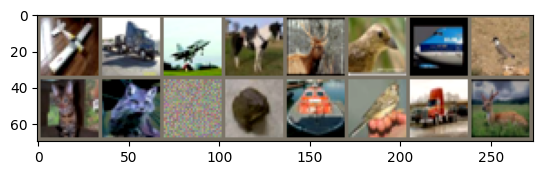

GroundTruth:  plane truck plane horse deer  bird  plane bird  cat   cat   noise frog  ship  bird  truck deer 
Predicted:  plane truck plane dog   deer  bird  car   bird  dog   car   noise frog  ship  frog  truck deer 


In [38]:
show_examples(classes_adv, combined_dataloader_test, model_adv)

In [39]:
show_accuracies(classes_adv, combined_dataloader_test, model_adv)

Accuracy for class: plane is 76.3 %
Accuracy for class: car   is 85.7 %
Accuracy for class: bird  is 61.8 %
Accuracy for class: cat   is 44.2 %
Accuracy for class: deer  is 63.5 %
Accuracy for class: dog   is 52.4 %
Accuracy for class: frog  is 80.8 %
Accuracy for class: horse is 69.4 %
Accuracy for class: ship  is 79.7 %
Accuracy for class: truck is 71.5 %
Accuracy for class: noise is 100.0 %

Accuracy on the test set: 0.785


In [44]:
# Generate based on original model
adv_target = classes_adv.index('frog')
m = GeneticSolver(model_org, image_size=image_size, verbosity=True, verbose_step=100, warm_start=True, early_stopping=False)
res, score = m.solve(fitness_class_probability_empty, n_generations=1000, verbose_step=500)

Generation #: best score
Generation  500 :  16.37130634898059
Generation  999 :  17.02287444557262


In [46]:
show_probabilities(res, model_adv, classes_adv)

Confidence scores:
plane: 0.0
car: 0.0
bird: 0.0
cat: 0.0
deer: 0.0
dog: 0.0
frog: 0.0
horse: 0.0
ship: 0.0
truck: 0.0
noise: 1.0

Label with highest confidence score: noise


In [47]:
# Generate based on new model
adv_target = classes_adv.index('frog')
m = GeneticSolver(model_adv, image_size=image_size, verbosity=True, verbose_step=100, warm_start=True, early_stopping=False)
res, score = m.solve(fitness_class_probability_empty, n_generations=1000, verbose_step=500)

Generation #: best score
Generation  500 :  10.131435270303356
Generation  999 :  10.851980120716515


In [48]:
show_probabilities(res, model_adv, classes_adv)

Confidence scores:
plane: 6.589005518157918e-23
car: 7.524339087034491e-22
bird: 1.2506568903722866e-19
cat: 5.0847165477527e-16
deer: 9.051869868647794e-17
dog: 5.766570526405225e-18
frog: 1.0
horse: 2.1204284268204945e-21
ship: 2.5610625510022164e-22
truck: 5.3565631529519844e-21
noise: 3.08120168802823e-39

Label with highest confidence score: frog


### So, adversarial training does not work on images generated using adversarial model :(